In [1]:
import logging
import numpy as np
import scipy

logging.basicConfig(level = logging.INFO)
log = logging.getLogger(__name__)

In [2]:
class Partitions:
    def __init__(self, data=None,
                 meshingScheme=None,
                 numParts=3,
                 alpha=0.05):
        import scipy

        if data is not None:
            # check that the data is in ordinal coordinates
            if not self.isOrdinal(data):
                print("Converting the data to ordinal...")
                # perform ordinal sampling (ranking) transformation
                xRanked = scipy.stats.rankdata(data[:, 0], method='ordinal')
                yRanked = scipy.stats.rankdata(data[:, 1], method='ordinal')

                xFloats = np.copy(data[:, 0])
                xFloats.sort()
                yFloats = np.copy(data[:, 1])
                yFloats.sort()

                self.xFloats = xFloats
                self.yFloats = yFloats

                data = np.column_stack((xRanked, yRanked))

                # and return an empty partition bucket

            # If there is data, set the bounding box to be the max and min in the data

            xmin = data[:, 0].min()
            xmax = data[:, 0].max()
            ymin = data[:, 1].min()
            ymax = data[:, 1].max()

            # Bordas de uma particao
            self.borders = {}
            self.borders['nodes'] = np.array([xmin, xmax, ymin, ymax])
            self.borders['npts'] = data.shape[0]
            self.numParts = numParts
            self.alpha = alpha

            # If there is data, use the chosen meshing scheme to build the partitions.
            if meshingScheme == 'DV' and self.isOrdinal(data):
                # Figure out
                self.partitionBucket = self.return_partition_DV(data=data,
                                                                borders=self.borders,
                                                                r=self.numParts,
                                                                alpha=self.alpha)
            else:  # meshingScheme == None
                # Note that right now, this will just do the dumb thing for every other input
                self.partitionBucket = [self.borders]
                #  set the partitions to just be the bounding box

        else:
            self.partitionBucket = []

    def convertOrdToFloat(self, partitionEntry):
        bdyList = partitionEntry['nodes'].copy()
        # Need to subtract one to deal with counting from
        # 0 vs counting from 1 problems
        xLow = int(bdyList[0])-1
        xHigh = int(bdyList[1])-1
        yLow = int(bdyList[2])-1
        yHigh = int(bdyList[3])-1

        if hasattr(self, 'xFloats'):
            xLowFloat = self.xFloats[xLow]
            xHighFloat = self.xFloats[xHigh]
            yLowFloat = self.yFloats[yLow]
            yHighFloat = self.yFloats[yHigh]
            convertedBdyList = [xLowFloat, xHighFloat, yLowFloat, yHighFloat]
            partitionEntry['nodes'] = convertedBdyList
            return partitionEntry
        else:
            print("You're trying to convert your ordinal data")
            print("back to floats, but you must have had ordinal")
            print("to begin with so I can't.  Exiting...")

    def __len__(self):
        return len(self.partitionBucket)

    def __getitem__(self, key):
        if hasattr(self, 'xFloats'):  # if the data wasn't ordinal
            entry = self.partitionBucket[key].copy()
            entry = self.convertOrdToFloat(entry)
            return entry
        else:
            return self.partitionBucket[key]

    def getOrdinal(self, key):
        # overrides the builtin magic method in the case where
        # you had non-ordinal data but still want the ordinal
        # stuff back.
        # If the data wasn't ordinal, this has the exact same
        # effect as self[key]
        return self.partitionBucket[key]

    def __iter__(self):
        # iterates over the converted entries in the
        # parameter bucket
        if hasattr(self, 'xFloats'):
            return map(self.convertOrdToFloat, deepcopy(self.partitionBucket))
        else:
            return iter(self.partitionBucket)

    def iterOrdinal(self):
        # functions just like iter magic method without
        # converting each entry back to its float
        return iter(self.partitionBucket)

    def __str__(self):
        """!
        @brief Nicely prints all currently set values in the bucket.
        """
        attrs = vars(self)
        output = ''
        output += 'Variables in partition bucket\n'
        output += '---\n'
        for key in attrs.keys():
            output += str(key) + ' : '
            output += str(attrs[key]) + '\n'
            output += '---\n'
        return output

    def plot(self):
        import matplotlib.pyplot as plt
        import matplotlib
        # plot the partitions
        fig1, ax1 = plt.subplots()
        for binNode in self:
            # print(binNode)
            # get the bottom left corner
            corner = (binNode['nodes'][0], binNode['nodes'][2])

            # get the width and height
            width = binNode['nodes'][1] - binNode['nodes'][0]
            height = binNode['nodes'][3] - binNode['nodes'][2]

            # add the corresponding rectangle
            ax1.add_patch(matplotlib.patches.Rectangle(
                corner, width, height, fill=False))

        # Doesn't show unless we do this
        plt.axis('tight')
        plt.show()

    # helper function for error checking. Used to make sure input is in
    # ordinarl coordinates. It checks that when the two data columns are sorted
    # they are each equal to an ordered vector with the same number of rows.
    def isOrdinal(self, dd):
        return np.all(np.equal(np.sort(dd, axis=0),
                               np.reshape(np.repeat(np.arange(start=1, stop=dd.shape[0]+1),
                                                    2), (dd.shape[0], 2))))

    # data: is a manyx2 numpy array that contains all the original data
    # borders: a dictionary that contains 'nodes' with a numpyu array of Xmin, Xmax, Ymin, Ymax,
    # and 'npts' which contains the number of points in the bin
    # r: is the number of partitions
    # alpha: the significance level to test for independence

    def return_partition_DV(self, data, borders, r=2, alpha=0.05):
        import scipy
        # extract the bin boundaries
        Xmin = borders['nodes'][0]
        Xmax = borders['nodes'][1]
        Ymin = borders['nodes'][2]
        Ymax = borders['nodes'][3]

        # find the number of bins
    #    numBins = r ** 2
        idx = np.where((data[:, 0] >= Xmin)
                       & (data[:, 0] <= Xmax)
                       & (data[:, 1] >= Ymin)
                       & (data[:, 1] <= Ymax))
    
        log.info(f'Number of bins: {idx}')

        # extract the points in the bin
        Xsub = data[idx, 0]
        Ysub = data[idx, 1]

        log.info(f'Points in the bin {Xsub} and {Ysub}')

    #    print(Xsub.shape, '\t', Ysub.shape)

        # find the indices of the points in the x- and y-patches
        idx_x = np.where((data[:, 0] >= Xmin) & (data[:, 0] <= Xmax))
        idx_y = np.where((data[:, 1] >= Ymin) & (data[:, 1] <= Ymax))

        log.info(f'indices: {idx_x} & {idx_y}')

        # get the subpartitions
        ai = np.floor(np.percentile(
            data[idx_x, 0], 1/r * np.arange(1, r) * 100))
        bj = np.floor(np.percentile(
            data[idx_y, 1], 1/r * np.arange(1, r) * 100))

        log.info(f'Subpartitions {ai} & {bj}')

        # get the bin edges
        edges1 = np.concatenate(([Xmin], ai, [Xmax]))
        edges2 = np.concatenate(([Ymin], bj, [Ymax]))

        # first exit criteria: we cannot split inot unique boundaries any more
        # preallocate the partition list
        partitions = []
        if (len(np.unique(edges1, return_counts=True)[1]) < r + 1 or
                len(np.unique(edges2, return_counts=True)[1]) < r + 1):

            # reject futher partitions, and return original bin
            partitions.insert(0, {'nodes': np.array([Xmin, Xmax, Ymin, Ymax]),
                                  'npts': len(idx[0])})
            return partitions

        # figure out the shift in the edges so that boundaries do not overlap
        xShift = np.zeros((2 * r, 2 * r))
        yShift = xShift
        xShift[:, 1:-1] = np.tile(np.array([[-1, 0]]), (2 * r, r - 1))
        yShift = xShift.T

        # find the boundaries for each bin
        # duplicate inner nodes for x mesh
        dupMidNodesX = np.append(np.insert(np.repeat((edges1[1:-1]), 2, axis=0),
                                           0, edges1[0]), edges1[-1])

        # duplicate inner nodes for y mesh
        dupMidNodesY = np.append(np.insert(np.repeat((edges2[1:-1]), 2, axis=0),
                                           0, edges2[0]), edges2[-1])
        # reshape
        dupMidNodesY = np.reshape(dupMidNodesY, (-1, 1))

        # now find the nodes for each bin
        xBinBound = dupMidNodesX + xShift
        yBinBound = dupMidNodesY + yShift
        # find the number of points in each bin, and put this info into array
        binned_data = scipy.stats.binned_statistic_2d(Xsub.flatten(), Ysub.flatten(), None, 'count',
                                                      bins=[edges1, edges2])
        # get the counts. Flatten columnwise to match the bin definition in the
        # loop that creates the dictionaries below
        binCounts = binned_data.statistic.flatten('F')

        # define an empty list to hold the dictionaries of the fresh partitions
        bins = []
        # create dictionaries for each bin
        # start with the loop over y
        # note how the loop counts were obtained above to match the convention
        # here
        for yInd in np.arange(r):
            # this is the loop over x
            for xInd in np.arange(r):
                # get the bin number
                binNo = yInd * r + xInd
                xLow, xHigh = xBinBound[yInd, 2*xInd + np.arange(2)]
                yLow, yHigh = yBinBound[2*yInd + np.arange(2), xInd]
                bins.append({'nodes': np.array([xLow, xHigh, yLow, yHigh]),
                             'npts': binCounts[binNo]})

        # calculate the chi square statistic
        chi2 = scipy.stats.chisquare(binCounts)

        # check for independence and start recursion
        # if the chi2 test fails, do further partitioning:
        if (chi2.pvalue < alpha and Xmax != Xmin and Ymax != Ymin).all():
            for binInfo in bins:
                if binInfo['npts'] != 0:  # if the bin is not empty:
                    # append entries to the tuple
                    partitions.extend(self.return_partition_DV(data=data,
                                                               borders=binInfo,
                                                               r=r, alpha=alpha))

        # Second exit criteria:
        # if the partitions are independent, reject further partitioning and
        # save the orignal, unpartitioned bin
        elif len(idx[0]) != 0:
            partitions.insert(0, {'nodes': np.array([Xmin, Xmax, Ymin, Ymax]),
                                  'npts': len(idx[0])})

        return partitions
    

In [72]:
x = [1,2,2,2,3,3,6,7,8,3,6,5,9,10,11]
y = [1,1,3,3,7,4,3,1,2,4,7,8,5,9,10]

In [73]:
ycat = ['a','a','a','a','b','a','b','a','b','b','b','b','a','b','b']

In [74]:
ycatRanked = scipy.stats.rankdata(ycat, method = 'ordinal')

In [75]:
ycatRanked

array([ 1,  2,  3,  4,  8,  5,  9,  6, 10, 11, 12, 13,  7, 14, 15])

In [65]:
xRanked = scipy.stats.rankdata(x, method = 'ordinal')

In [66]:
yRanked = scipy.stats.rankdata(y, method = 'ordinal')

In [70]:
print(xRanked)
print(yRanked)

[ 1  2  3  4  5  6  9 11 12  7 10  8 13 14 15]
[ 1  2  5  6 11  8  7  3  4  9 12 13 10 14 15]


In [67]:
data = np.column_stack((xRanked, yRanked))

In [68]:
xmin = data[:, 0].min()
xmax = data[:, 0].max()
ymin = data[:, 1].min()
ymax = data[:, 1].max()

In [69]:
xmin
xmax
ymin
ymax

15

In [9]:
borders = {}
borders['nodes'] = np.array([xmin, xmax, ymin, ymax])
borders['pts'] = data.shape[0]
numParts = 4
alpha = 0.05

In [10]:
Xmin = borders['nodes'][0]
Xmax = borders['nodes'][1]
Ymin = borders['nodes'][2]
Ymax = borders['nodes'][3]

In [11]:
data

array([[ 1,  1],
       [ 2,  2],
       [ 3,  5],
       [ 4,  6],
       [ 5, 10],
       [ 6,  8],
       [ 9,  7],
       [11,  3],
       [12,  4],
       [ 7,  9],
       [10, 11],
       [ 8, 12]])

In [12]:
(data[:, 0] >= Xmin)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [13]:
#montar indice para retornar ou nao os valores
idx = np.where((data[:, 0] >= Xmin)
           & (data[:, 0] <= Xmax)
           & (data[:, 1] >= Ymin)
           & (data[:, 1] <= Ymax))

In [14]:
print(idx)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)


In [15]:
# extract the points in the bin
Xsub = data[idx, 0]
Ysub = data[idx, 1]

In [16]:
Xsub

array([[ 1,  2,  3,  4,  5,  6,  9, 11, 12,  7, 10,  8]])

In [17]:
Ysub

array([[ 1,  2,  5,  6, 10,  8,  7,  3,  4,  9, 11, 12]])

In [18]:
idx_x = np.where((data[:, 0] >= Xmin) & (data[:, 0] <= Xmax))
idx_y = np.where((data[:, 1] >= Ymin) & (data[:, 1] <= Ymax))

In [19]:
print(idx_x)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)


In [20]:
print(idx_y)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)


In [21]:
r = 2

In [22]:
percentil = 1/r * np.arange(1, r) * 100
print(percentil)

ai = np.floor(np.percentile(data[idx_x, 0], percentil))
bj = np.floor(np.percentile(data[idx_y, 1], percentil))

[50.]


In [23]:
# retorna onde sera realizado o particionamento

In [24]:
# get the bin edges
edges1 = np.concatenate(([Xmin], ai, [Xmax]))
edges2 = np.concatenate(([Ymin], bj, [Ymax]))

In [25]:
edges1

array([ 1.,  6., 12.])

In [41]:
# figure out the shift in the edges so that boundaries do not overlap
xShift = np.zeros((2 * r, 2 * r))
yShift = xShift
xShift[:, 1:-1] = np.tile(np.array([[-1, 0]]), (2 * r, r - 1))
yShift = xShift.T

In [42]:
np.tile(np.array([[-1, 0]]), (2 * r, r - 1))

array([[-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0]])

In [43]:
np.repeat(1,2)

array([1, 1])

In [44]:
dupMidNodesX = np.append(
np.insert(
    np.repeat(
            (edges1[1:-1]), 2, axis=0
        ),
        0,
        edges1[0]
    ), 
edges1[-1]
)

In [45]:
dupMidNodesX

array([ 1.,  6.,  6., 12.])

In [46]:
# duplicate inner nodes for y mesh
dupMidNodesY = np.append(np.insert(np.repeat((edges2[1:-1]), 2, axis=0),
                                   0, edges2[0]), edges2[-1])

In [47]:
dupMidNodesY

array([ 1.,  6.,  6., 12.])

In [48]:
dupMidNodesY = np.reshape(dupMidNodesY, (-1, 1))

In [49]:
dupMidNodesY

array([[ 1.],
       [ 6.],
       [ 6.],
       [12.]])

In [50]:
# now find the nodes for each bin
xBinBound = dupMidNodesX + xShift
yBinBound = dupMidNodesY + yShift

In [51]:
xBinBound

array([[ 1.,  5.,  6., 12.],
       [ 1.,  5.,  6., 12.],
       [ 1.,  5.,  6., 12.],
       [ 1.,  5.,  6., 12.]])

In [52]:
yBinBound

array([[ 1.,  1.,  1.,  1.],
       [ 5.,  5.,  5.,  5.],
       [ 6.,  6.,  6.,  6.],
       [12., 12., 12., 12.]])

### Ele de fato cria sim bins

In [54]:
# find the number of points in each bin, and put this info into array
binned_data = scipy.stats.binned_statistic_2d(Xsub.flatten(), Ysub.flatten(), None, 'count',
                                              bins=[edges1, edges2])

In [55]:
binned_data

BinnedStatistic2dResult(statistic=array([[3., 2.],
       [2., 5.]]), x_edge=array([ 1.,  6., 12.]), y_edge=array([ 1.,  6., 12.]), binnumber=array([ 5,  5,  5,  6,  6, 10, 10,  9,  9, 10, 10, 10]))

In [56]:
binCounts = binned_data.statistic.flatten('F')

In [57]:
binCounts

array([3., 2., 2., 5.])

In [62]:
binCounts

array([3., 2., 2., 5.])

In [59]:
bins = []

In [60]:
for yInd in np.arange(r):
    # this is the loop over x
    for xInd in np.arange(r):
        # get the bin number
        binNo = yInd * r + xInd
        xLow, xHigh = xBinBound[yInd, 2*xInd + np.arange(2)]
        yLow, yHigh = yBinBound[2*yInd + np.arange(2), xInd]
        bins.append({'nodes': np.array([xLow, xHigh, yLow, yHigh]),
                     'npts': binCounts[binNo]})

In [61]:
bins

[{'nodes': array([1., 5., 1., 5.]), 'npts': 3.0},
 {'nodes': array([ 6., 12.,  1.,  5.]), 'npts': 2.0},
 {'nodes': array([ 1.,  5.,  6., 12.]), 'npts': 2.0},
 {'nodes': array([ 6., 12.,  6., 12.]), 'npts': 5.0}]

In [76]:
for bin in bins:
    print(bin)

{'nodes': array([1., 5., 1., 5.]), 'npts': 3.0}
{'nodes': array([ 6., 12.,  1.,  5.]), 'npts': 2.0}
{'nodes': array([ 1.,  5.,  6., 12.]), 'npts': 2.0}
{'nodes': array([ 6., 12.,  6., 12.]), 'npts': 5.0}


(0.44999999999999996, 12.55, 0.44999999999999996, 12.55)

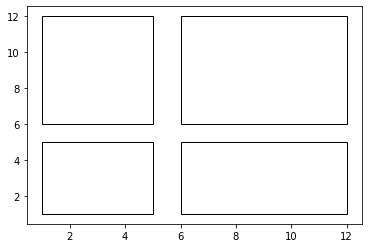

In [78]:
import matplotlib.pyplot as plt
import matplotlib
# plot the partitions
fig1, ax1 = plt.subplots()
for binNode in bins:
    # print(binNode)
    # get the bottom left corner
    corner = (binNode['nodes'][0], binNode['nodes'][2])

    # get the width and height
    width = binNode['nodes'][1] - binNode['nodes'][0]
    height = binNode['nodes'][3] - binNode['nodes'][2]

    # add the corresponding rectangle
    ax1.add_patch(matplotlib.patches.Rectangle(
        corner, width, height, fill=False))

# Doesn't show unless we do this
plt.axis('tight')